## Random Forest Regressor - Usando diferenças

In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

from scipy import stats
from scipy.stats import boxcox

from timeit import default_timer as timer
from dateutil.parser import parse
from datetime import datetime

import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown
#get_ipython().run_line_magic('matplolib', 'inline')

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:.6f}'.format

plt.style.use('bmh')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = '17'

### Funções Auxiliares

In [2]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def sum_thousand(x):    
    return round(((x.sum())/1000.0),2)

def media_agregada(x):    

    return round(((x.sum())/12.0),0)

def ignore_nans(a,b):
    index = ~a.isnull() & ~b.isnull()
    return a[index], b[index]

#Função para avaliação de métricas de erros
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def smape(y_true,y_pred):
        num = np.abs(np.subtract(y_true,y_pred))
        den = (np.abs(y_true) + np.abs(y_pred)) / 2
        ratio = num/den
        return ratio.mean()

    print(f'Mean_Squared_Error_(MSE) is : {mean_squared_error(y_true,y_pred)}')

    print(f'Root_Mean_Squared_Error_(RMSE) is : {mean_squared_error(y_true,y_pred, squared=False)}')

    print(f'Mean_Absolute_Error_(MAE) is : {mean_absolute_error(y_true,y_pred)}')

    print(f'Mean_Absolute_Percentage_Error (MAPE) is : {mean_absolute_percentage_error(y_true,y_pred)}')

    print(f'Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : {smape(y_true,y_pred)}')

    print(f'Coefficient of determination R^2 is : {r2_score(y_true,y_pred)}', end = '\n\n')

    return

#Função para avaliação da estacionaridade dos dados da série temporal
def Augmented_Dickey_Fuller_Test_func(series, column_name):

    print(f'Results of Dickey-Fuller Test for column {column_name}')

    dftest = adfuller(series, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=[   'Test Statistic',
                                                'p-value',
                                                'No Lags Used',
                                                'Number of Observartions Used'])
    
    for key, value in dftest[4].items():
        
        dfoutput['Critical Value (%s)' %key] = value

    print(dfoutput)

    if dftest[1] <= 0.05:
        print('Conclusion:====>')
        print('Reject the null hypothesis')
        print('Data is stationary')
    else:
        print('Conclusion:====>')
        print('Fail to reject the null hypothesis')
        print('Data is non-stationary')


def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[col + '_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[col].cumsum()
    return df_res

### Carregamento e leitura dos dados

In [3]:
grupo = 'Adesão - Grande - Cooperativa Médica' 

grupo_csv = "ade_g_coopmed.csv"

#path = r'D:\TCC\TCC\codigos\preparacao_dados\analise_agrupadas\adesao\porte_grande\adesao_grande_cooperativa_medica' + '\\' + grupo_csv

ans = pd.read_csv(grupo_csv, sep=';', decimal= ',', encoding='mbcs')

#Amostra do dataframe
ans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ano          616 non-null    int64  
 1   cd_ops       616 non-null    int64  
 2   trimestre    616 non-null    object 
 3   receita      616 non-null    float64
 4   despesa      616 non-null    float64
 5   benef        616 non-null    int64  
 6   modalidade   616 non-null    object 
 7   port_ops     616 non-null    object 
 8   contratacao  616 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 43.4+ KB


In [4]:
ind_econ = 'ind_econ.csv'

df_ind_econ = pd.read_csv(ind_econ, sep=';', decimal= ',', encoding='mbcs')

df_ind_econ = df_ind_econ[(df_ind_econ.trimestre > '2017Q4') & (df_ind_econ.trimestre < '2022Q1')]

df_ind_econ = df_ind_econ.reset_index(drop=True)

df_ind_econ['trimestre'] = pd.PeriodIndex(df_ind_econ['trimestre'], freq="Q")

df_ind_econ['Dolar_diff'] = df_ind_econ['Dolar'].diff(1)

df_ind_econ['PNAD_diff'] = df_ind_econ['PNAD'].diff(1) 

df_ind_econ.info()

df_ind_econ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype        
---  ------      --------------  -----        
 0   trimestre   16 non-null     period[Q-DEC]
 1   IPCA        16 non-null     float64      
 2   Selic       16 non-null     float64      
 3   Dolar       16 non-null     float64      
 4   PNAD        16 non-null     float64      
 5   Dolar_diff  15 non-null     float64      
 6   PNAD_diff   15 non-null     float64      
dtypes: float64(6), period[Q-DEC](1)
memory usage: 1.0 KB


,trimestre,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
0,2018Q1,0.007015,0.000158,3.245100,4285.000000,NaN,NaN
1,2018Q2,0.018887,0.000156,3.457233,4279.000000,0.212133,-6.000000
2,2018Q3,0.007209,0.000158,3.853900,4329.000000,0.396667,50.000000
3,2018Q4,0.003894,0.000152,3.904500,4424.000000,0.050600,95.000000
4,2019Q1,0.015070,0.000150,3.776467,4419.000000,-0.128033,-5.000000
5,2019Q2,0.007108,0.000153,3.903500,4327.000000,0.127033,-92.000000
6,2019Q3,0.002601,0.000153,3.882133,4286.000000,-0.021367,-41.000000
7,2019Q4,0.017675,0.000123,4.131167,4410.000000,0.249034,124.000000
8,2020Q1,0.005308,0.000101,4.191133,4355.000000,0.059966,-55.000000
9,2020Q2,-0.004306,0.000073,5.272333,4009.000000,1.081200,-346.000000


In [5]:
ans_agrup = ans.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                    'despesa':lambda x: sum_billion(x),
                                                                    'benef': 'sum',
                                                                    'cd_ops':lambda x: x.nunique()})

ans_agrup['pct_despesa'] = ans_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_agrup = ans_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_agrup = ans_agrup[(ans_agrup.trimestre > '2017Q4') & (ans_agrup.trimestre < '2022Q1')]

ans_agrup[['n_ops','benef']] = ans_agrup[['n_ops','benef']].astype('int')

ans_agrup['ano'] = ans_agrup['trimestre'].str[:4]

ans_agrup['ano'] = ans_agrup['ano'].astype('int')

ans_agrup['n_tri'] = ans_agrup['trimestre'].str[-1:]

ans_agrup['n_tri'] = ans_agrup['n_tri'].astype('float')

ans_agrup['n_tri_l1'] = ans_agrup['n_tri'].shift(1)

ans_agrup['trimestre'] = pd.PeriodIndex(ans_agrup['trimestre'], freq="Q")

#Tratamento dados benef

ans_agrup['benefm'] = ans_agrup['benef'] / 3.0

ans_agrup['benefm_diff'] = ans_agrup['benefm'].diff(1)
ans_agrup['benefm_diff_l1'] = ans_agrup['benefm_diff'].shift(1)
ans_agrup['benefm_diff_l2'] = ans_agrup['benefm_diff'].shift(2)


#Tratamento dados receita
ans_agrup['receita_l1'] = ans_agrup['receita'].shift(1)
ans_agrup['receita_l2'] = ans_agrup['receita'].shift(2)

ans_agrup['receita_diff'] = ans_agrup['receita'].diff(1)
ans_agrup['receita_diff_l1'] = ans_agrup['receita_diff'].shift(1)
ans_agrup['receita_diff_l2'] = ans_agrup['receita_diff'].shift(2)

#Tratamento dados despesa

ans_agrup['despesa_l1'] = ans_agrup['despesa'].shift(1)
ans_agrup['despesa_l2'] = ans_agrup['despesa'].shift(2)

ans_agrup['despesa_diff'] = ans_agrup['despesa'].diff(1)
ans_agrup['despesa_diff_l1'] = ans_agrup['despesa_diff'].shift(1)
ans_agrup['despesa_diff_l2'] = ans_agrup['despesa_diff'].shift(2)

ans_agrup['despesa_diff2'] = ans_agrup['despesa'].diff(2)
ans_agrup['despesa_diff2_l1'] = ans_agrup['despesa_diff2'].shift(1)
ans_agrup['despesa_diff2_l2'] = ans_agrup['despesa_diff2'].shift(2)

#Variáveis Dummies

#ans_agrup['dmy_outlier'] = np.where(ans_agrup['trimestre'] == '2019Q1',0.0,1.0)

ans_agrup['dmy_covid'] = np.where((ans_agrup['trimestre'] >= '2020Q1') & (ans_agrup['trimestre'] <= '2020Q3'),0.0,1.0)

ans_agrup.info()

ans_agrup

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype        
---  ------            --------------  -----        
 0   trimestre         16 non-null     period[Q-DEC]
 1   receita           16 non-null     float64      
 2   despesa           16 non-null     float64      
 3   benef             16 non-null     int32        
 4   n_ops             16 non-null     int32        
 5   pct_despesa       16 non-null     float64      
 6   ano               16 non-null     int32        
 7   n_tri             16 non-null     float64      
 8   n_tri_l1          15 non-null     float64      
 9   benefm            16 non-null     float64      
 10  benefm_diff       15 non-null     float64      
 11  benefm_diff_l1    14 non-null     float64      
 12  benefm_diff_l2    13 non-null     float64      
 13  receita_l1        15 non-null     float64      
 14  receita_l2        14 non-null     float64   

,trimestre,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff_l1,benefm_diff_l2,receita_l1,receita_l2,receita_diff,receita_diff_l1,receita_diff_l2,despesa_l1,despesa_l2,despesa_diff,despesa_diff_l1,despesa_diff_l2,despesa_diff2,despesa_diff2_l1,despesa_diff2_l2,dmy_covid
0,2018Q1,2.150000,1.580000,1655264,38,73.490000,2018,1.000000,NaN,551754.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
1,2018Q2,2.160000,1.640000,1667369,38,75.930000,2018,2.000000,1.000000,555789.666667,4035.000000,NaN,NaN,2.150000,NaN,0.010000,NaN,NaN,1.580000,NaN,0.060000,NaN,NaN,NaN,NaN,NaN,1.000000
2,2018Q3,2.290000,1.850000,1678692,38,80.790000,2018,3.000000,2.000000,559564.000000,3774.333333,4035.000000,NaN,2.160000,2.150000,0.130000,0.010000,NaN,1.640000,1.580000,0.210000,0.060000,NaN,0.270000,NaN,NaN,1.000000
3,2018Q4,2.380000,1.250000,1693379,38,52.520000,2018,4.000000,3.000000,564459.666667,4895.666667,3774.333333,4035.000000,2.290000,2.160000,0.090000,0.130000,0.010000,1.850000,1.640000,-0.600000,0.210000,0.060000,-0.390000,0.270000,NaN,1.000000
4,2019Q1,2.370000,1.870000,1700602,38,78.900000,2019,1.000000,4.000000,566867.333333,2407.666667,4895.666667,3774.333333,2.380000,2.290000,-0.010000,0.090000,0.130000,1.250000,1.850000,0.620000,-0.600000,0.210000,0.020000,-0.390000,0.270000,1.000000
5,2019Q2,2.460000,1.980000,1730500,38,80.490000,2019,2.000000,1.000000,576833.333333,9966.000000,2407.666667,4895.666667,2.370000,2.380000,0.090000,-0.010000,0.090000,1.870000,1.250000,0.110000,0.620000,-0.600000,0.730000,0.020000,-0.390000,1.000000
6,2019Q3,2.550000,1.950000,1733529,38,76.470000,2019,3.000000,2.000000,577843.000000,1009.666667,9966.000000,2407.666667,2.460000,2.370000,0.090000,0.090000,-0.010000,1.980000,1.870000,-0.030000,0.110000,0.620000,0.080000,0.730000,0.020000,1.000000
7,2019Q4,2.650000,2.080000,1757501,38,78.490000,2019,4.000000,3.000000,585833.666667,7990.666667,1009.666667,9966.000000,2.550000,2.460000,0.100000,0.090000,0.090000,1.950000,1.980000,0.130000,-0.030000,0.110000,0.100000,0.080000,0.730000,1.000000
8,2020Q1,2.750000,2.100000,1876410,39,76.360000,2020,1.000000,4.000000,625470.000000,39636.333333,7990.666667,1009.666667,2.650000,2.550000,0.100000,0.100000,0.090000,2.080000,1.950000,0.020000,0.130000,-0.030000,0.150000,0.100000,0.080000,0.000000
9,2020Q2,2.790000,1.750000,1892513,39,62.720000,2020,2.000000,1.000000,630837.666667,5367.666667,39636.333333,7990.666667,2.750000,2.650000,0.040000,0.100000,0.100000,2.100000,2.080000,-0.350000,0.020000,0.130000,-0.330000,0.150000,0.100000,0.000000


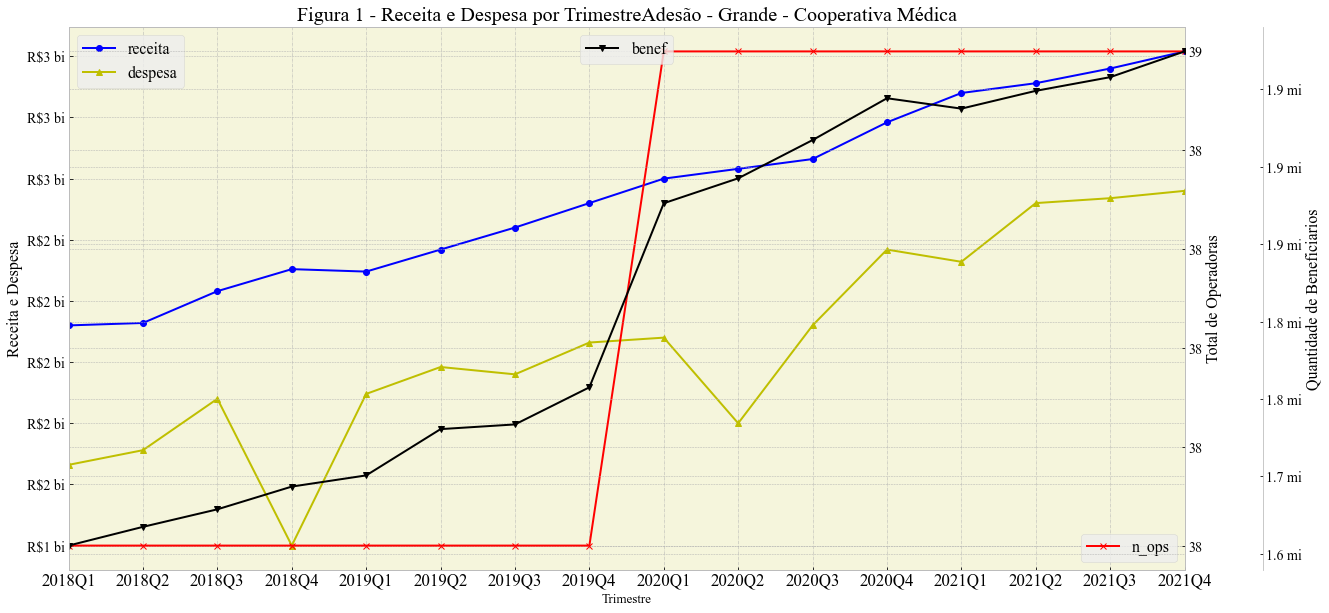

In [6]:
df_plot = ans_agrup.copy()

df_plot.set_index('trimestre', inplace=True)

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre' + grupo,fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks.astype(int), fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'lower right', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mi'.format(x/1e6) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.show()

del df_plot

In [7]:
ans_agrup = ans_agrup.merge(df_ind_econ, how='left', on='trimestre')

ans_agrup

,trimestre,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff_l1,benefm_diff_l2,receita_l1,receita_l2,receita_diff,receita_diff_l1,receita_diff_l2,despesa_l1,despesa_l2,despesa_diff,despesa_diff_l1,despesa_diff_l2,despesa_diff2,despesa_diff2_l1,despesa_diff2_l2,dmy_covid,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
0,2018Q1,2.150000,1.580000,1655264,38,73.490000,2018,1.000000,NaN,551754.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.007015,0.000158,3.245100,4285.000000,NaN,NaN
1,2018Q2,2.160000,1.640000,1667369,38,75.930000,2018,2.000000,1.000000,555789.666667,4035.000000,NaN,NaN,2.150000,NaN,0.010000,NaN,NaN,1.580000,NaN,0.060000,NaN,NaN,NaN,NaN,NaN,1.000000,0.018887,0.000156,3.457233,4279.000000,0.212133,-6.000000
2,2018Q3,2.290000,1.850000,1678692,38,80.790000,2018,3.000000,2.000000,559564.000000,3774.333333,4035.000000,NaN,2.160000,2.150000,0.130000,0.010000,NaN,1.640000,1.580000,0.210000,0.060000,NaN,0.270000,NaN,NaN,1.000000,0.007209,0.000158,3.853900,4329.000000,0.396667,50.000000
3,2018Q4,2.380000,1.250000,1693379,38,52.520000,2018,4.000000,3.000000,564459.666667,4895.666667,3774.333333,4035.000000,2.290000,2.160000,0.090000,0.130000,0.010000,1.850000,1.640000,-0.600000,0.210000,0.060000,-0.390000,0.270000,NaN,1.000000,0.003894,0.000152,3.904500,4424.000000,0.050600,95.000000
4,2019Q1,2.370000,1.870000,1700602,38,78.900000,2019,1.000000,4.000000,566867.333333,2407.666667,4895.666667,3774.333333,2.380000,2.290000,-0.010000,0.090000,0.130000,1.250000,1.850000,0.620000,-0.600000,0.210000,0.020000,-0.390000,0.270000,1.000000,0.015070,0.000150,3.776467,4419.000000,-0.128033,-5.000000
5,2019Q2,2.460000,1.980000,1730500,38,80.490000,2019,2.000000,1.000000,576833.333333,9966.000000,2407.666667,4895.666667,2.370000,2.380000,0.090000,-0.010000,0.090000,1.870000,1.250000,0.110000,0.620000,-0.600000,0.730000,0.020000,-0.390000,1.000000,0.007108,0.000153,3.903500,4327.000000,0.127033,-92.000000
6,2019Q3,2.550000,1.950000,1733529,38,76.470000,2019,3.000000,2.000000,577843.000000,1009.666667,9966.000000,2407.666667,2.460000,2.370000,0.090000,0.090000,-0.010000,1.980000,1.870000,-0.030000,0.110000,0.620000,0.080000,0.730000,0.020000,1.000000,0.002601,0.000153,3.882133,4286.000000,-0.021367,-41.000000
7,2019Q4,2.650000,2.080000,1757501,38,78.490000,2019,4.000000,3.000000,585833.666667,7990.666667,1009.666667,9966.000000,2.550000,2.460000,0.100000,0.090000,0.090000,1.950000,1.980000,0.130000,-0.030000,0.110000,0.100000,0.080000,0.730000,1.000000,0.017675,0.000123,4.131167,4410.000000,0.249034,124.000000
8,2020Q1,2.750000,2.100000,1876410,39,76.360000,2020,1.000000,4.000000,625470.000000,39636.333333,7990.666667,1009.666667,2.650000,2.550000,0.100000,0.100000,0.090000,2.080000,1.950000,0.020000,0.130000,-0.030000,0.150000,0.100000,0.080000,0.000000,0.005308,0.000101,4.191133,4355.000000,0.059966,-55.000000
9,2020Q2,2.790000,1.750000,1892513,39,62.720000,2020,2.000000,1.000000,630837.666667,5367.666667,39636.333333,7990.666667,2.750000,2.650000,0.040000,0.100000,0.100000,2.100000,2.080000,-0.350000,0.020000,0.130000,-0.330000,0.150000,0.100000,0.000000,-0.004306,0.000073,5.272333,4009.000000,1.081200,-346.000000


In [8]:
ans_agrup.set_index('trimestre', inplace=True)

ans_agrup_full = ans_agrup.copy()

In [9]:
ans_agrup_full['benefm'].iloc[-1]

658163.0

In [10]:
ans_agrup = ans_agrup.dropna()

#informações sobre o data frame
ans_agrup.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 12 entries, 2019Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   receita           12 non-null     float64
 1   despesa           12 non-null     float64
 2   benef             12 non-null     int32  
 3   n_ops             12 non-null     int32  
 4   pct_despesa       12 non-null     float64
 5   ano               12 non-null     int32  
 6   n_tri             12 non-null     float64
 7   n_tri_l1          12 non-null     float64
 8   benefm            12 non-null     float64
 9   benefm_diff       12 non-null     float64
 10  benefm_diff_l1    12 non-null     float64
 11  benefm_diff_l2    12 non-null     float64
 12  receita_l1        12 non-null     float64
 13  receita_l2        12 non-null     float64
 14  receita_diff      12 non-null     float64
 15  receita_diff_l1   12 non-null     float64
 16  receita_diff_l2   12 non

In [11]:
columns_receita = ['receita', 'receita_diff', 'despesa', 'despesa_diff', 'benefm', 'benefm_diff']

ans_agrup

,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff_l1,benefm_diff_l2,receita_l1,receita_l2,receita_diff,receita_diff_l1,receita_diff_l2,despesa_l1,despesa_l2,despesa_diff,despesa_diff_l1,despesa_diff_l2,despesa_diff2,despesa_diff2_l1,despesa_diff2_l2,dmy_covid,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
trimestre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019Q1,2.370000,1.870000,1700602,38,78.900000,2019,1.000000,4.000000,566867.333333,2407.666667,4895.666667,3774.333333,2.380000,2.290000,-0.010000,0.090000,0.130000,1.250000,1.850000,0.620000,-0.600000,0.210000,0.020000,-0.390000,0.270000,1.000000,0.015070,0.000150,3.776467,4419.000000,-0.128033,-5.000000
2019Q2,2.460000,1.980000,1730500,38,80.490000,2019,2.000000,1.000000,576833.333333,9966.000000,2407.666667,4895.666667,2.370000,2.380000,0.090000,-0.010000,0.090000,1.870000,1.250000,0.110000,0.620000,-0.600000,0.730000,0.020000,-0.390000,1.000000,0.007108,0.000153,3.903500,4327.000000,0.127033,-92.000000
2019Q3,2.550000,1.950000,1733529,38,76.470000,2019,3.000000,2.000000,577843.000000,1009.666667,9966.000000,2407.666667,2.460000,2.370000,0.090000,0.090000,-0.010000,1.980000,1.870000,-0.030000,0.110000,0.620000,0.080000,0.730000,0.020000,1.000000,0.002601,0.000153,3.882133,4286.000000,-0.021367,-41.000000
2019Q4,2.650000,2.080000,1757501,38,78.490000,2019,4.000000,3.000000,585833.666667,7990.666667,1009.666667,9966.000000,2.550000,2.460000,0.100000,0.090000,0.090000,1.950000,1.980000,0.130000,-0.030000,0.110000,0.100000,0.080000,0.730000,1.000000,0.017675,0.000123,4.131167,4410.000000,0.249034,124.000000
2020Q1,2.750000,2.100000,1876410,39,76.360000,2020,1.000000,4.000000,625470.000000,39636.333333,7990.666667,1009.666667,2.650000,2.550000,0.100000,0.100000,0.090000,2.080000,1.950000,0.020000,0.130000,-0.030000,0.150000,0.100000,0.080000,0.000000,0.005308,0.000101,4.191133,4355.000000,0.059966,-55.000000
2020Q2,2.790000,1.750000,1892513,39,62.720000,2020,2.000000,1.000000,630837.666667,5367.666667,39636.333333,7990.666667,2.750000,2.650000,0.040000,0.100000,0.100000,2.100000,2.080000,-0.350000,0.020000,0.130000,-0.330000,0.150000,0.100000,0.000000,-0.004306,0.000073,5.272333,4009.000000,1.081200,-346.000000
2020Q3,2.830000,2.150000,1917215,39,75.970000,2020,3.000000,2.000000,639071.666667,8234.000000,5367.666667,39636.333333,2.790000,2.750000,0.040000,0.040000,0.100000,1.750000,2.100000,0.400000,-0.350000,0.020000,0.050000,-0.330000,0.150000,0.000000,0.012447,0.000051,5.307533,3837.000000,0.035200,-172.000000
2020Q4,2.980000,2.460000,1944236,39,82.550000,2020,4.000000,3.000000,648078.666667,9007.000000,8234.000000,5367.666667,2.830000,2.790000,0.150000,0.040000,0.040000,2.150000,1.750000,0.310000,0.400000,-0.350000,0.710000,0.050000,-0.330000,1.000000,0.031314,0.000047,5.458467,3841.000000,0.150934,4.000000
2021Q1,3.100000,2.410000,1937524,39,77.740000,2021,1.000000,4.000000,645841.333333,-2237.333333,9007.000000,8234.000000,2.980000,2.830000,0.120000,0.150000,0.040000,2.460000,2.150000,-0.050000,0.310000,0.400000,0.260000,0.710000,0.050000,1.000000,0.020525,0.000048,5.249900,3760.000000,-0.208567,-81.000000


receita


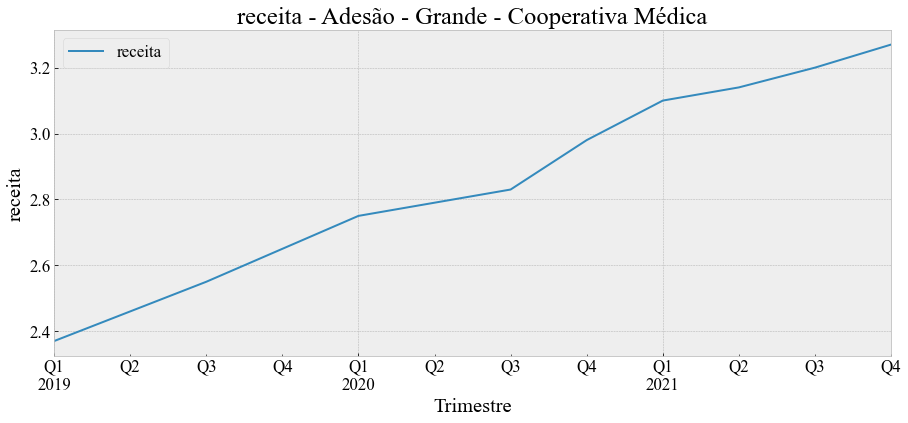

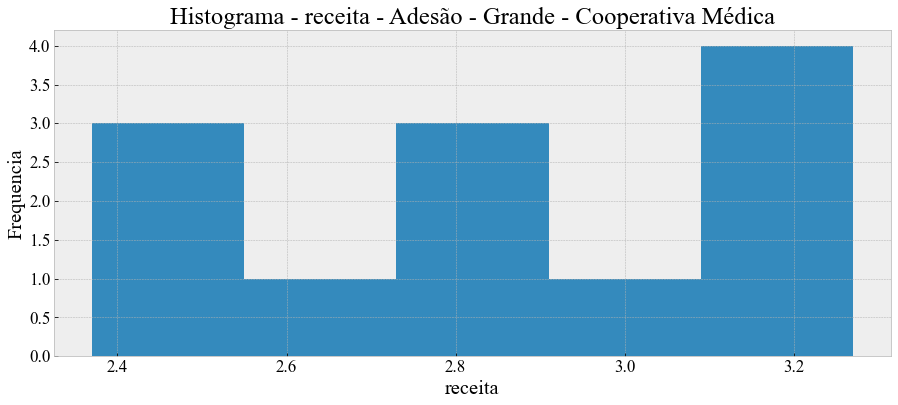

receita_diff


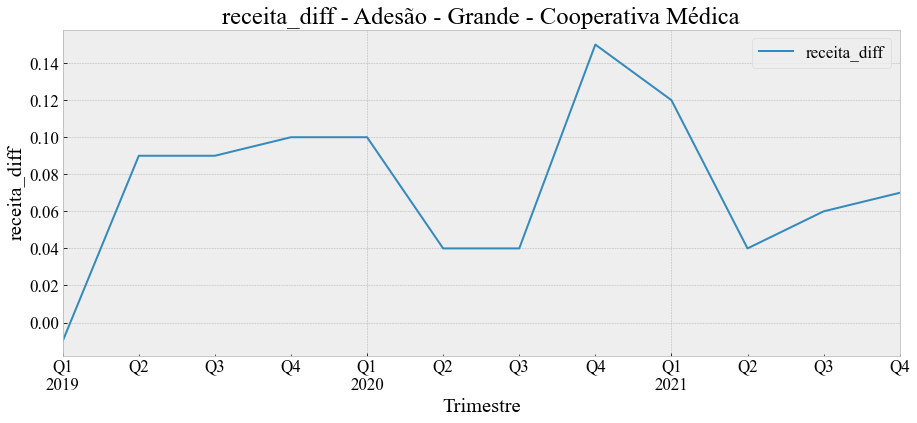

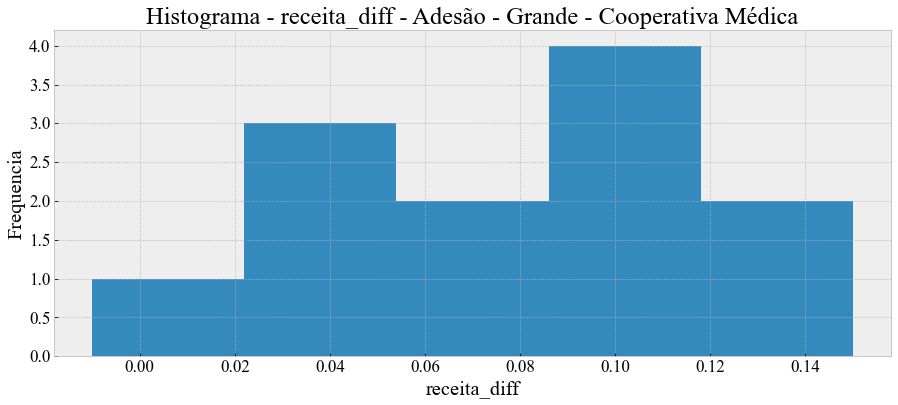

despesa


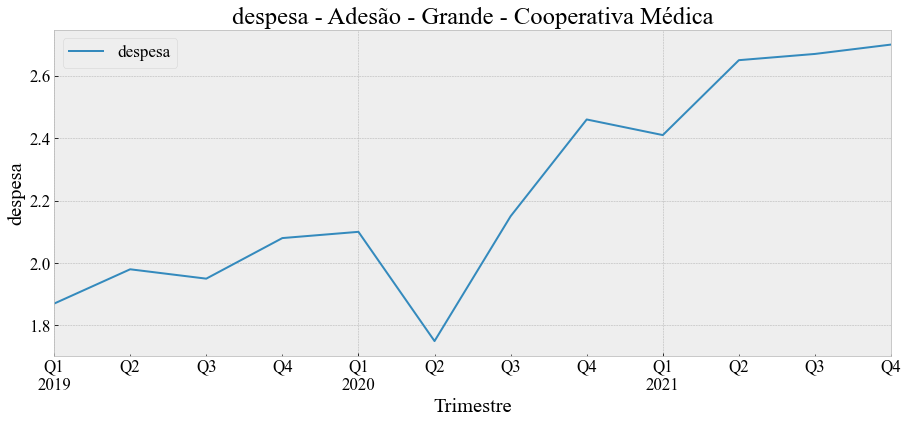

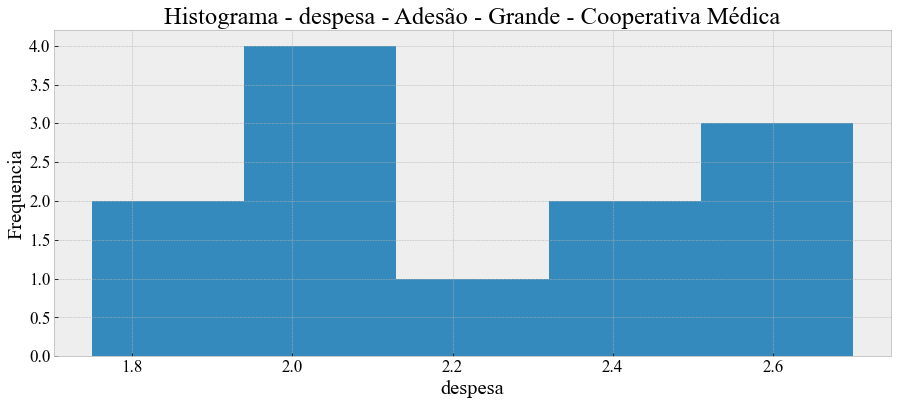

despesa_diff


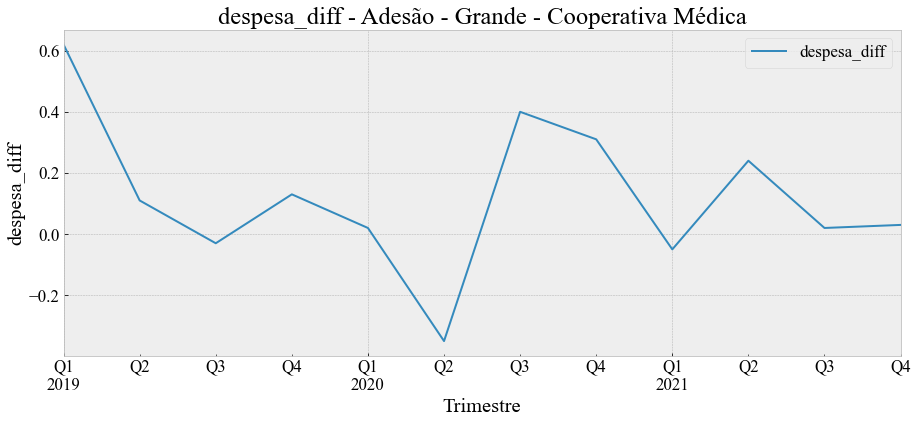

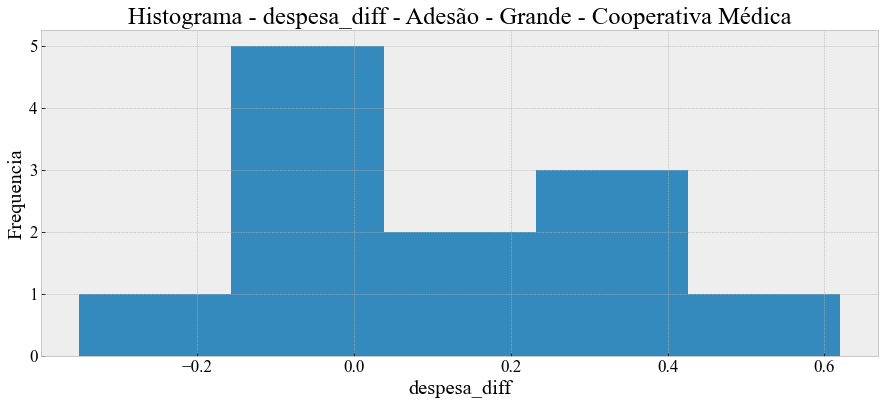

benefm


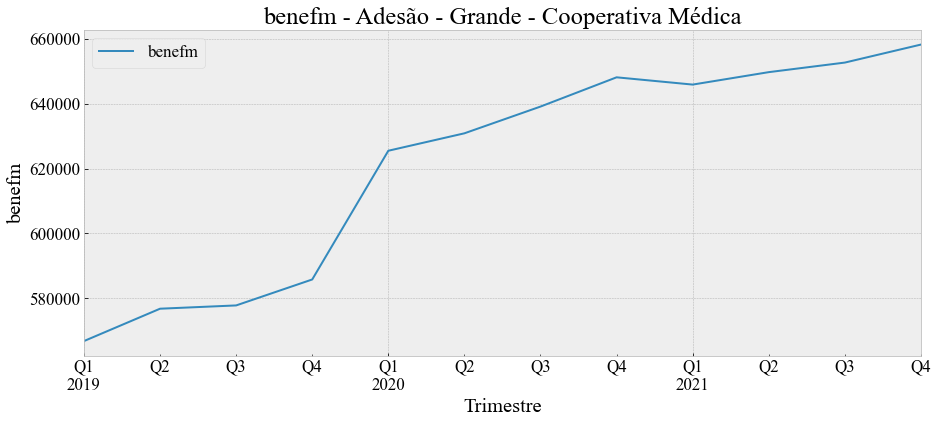

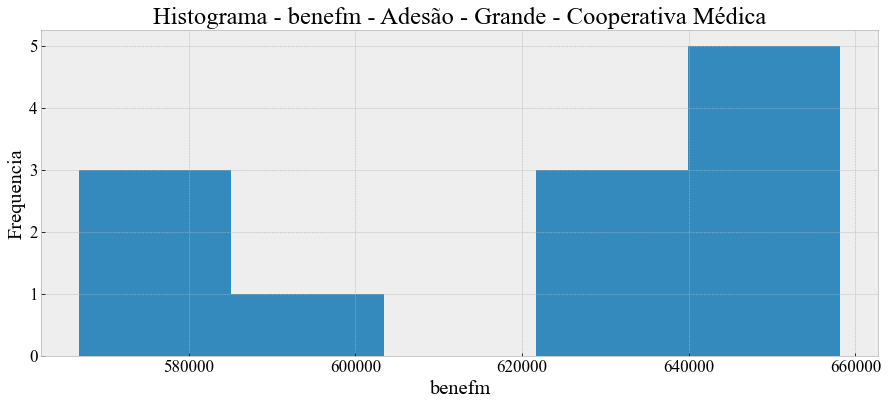

benefm_diff


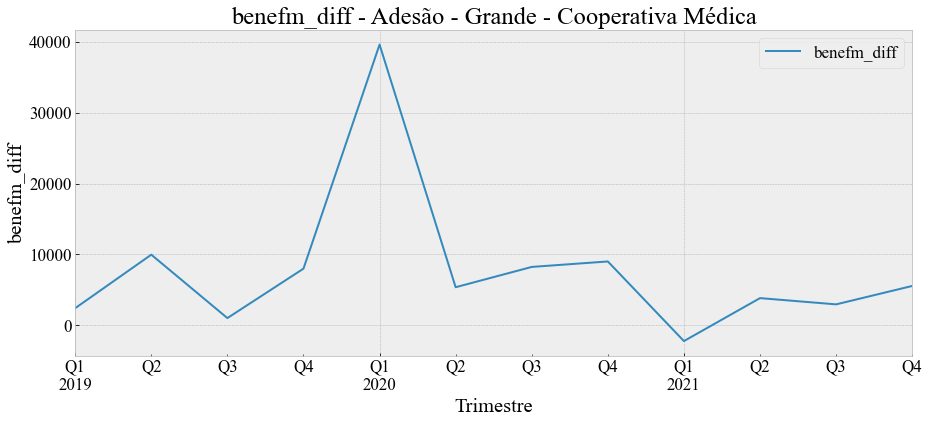

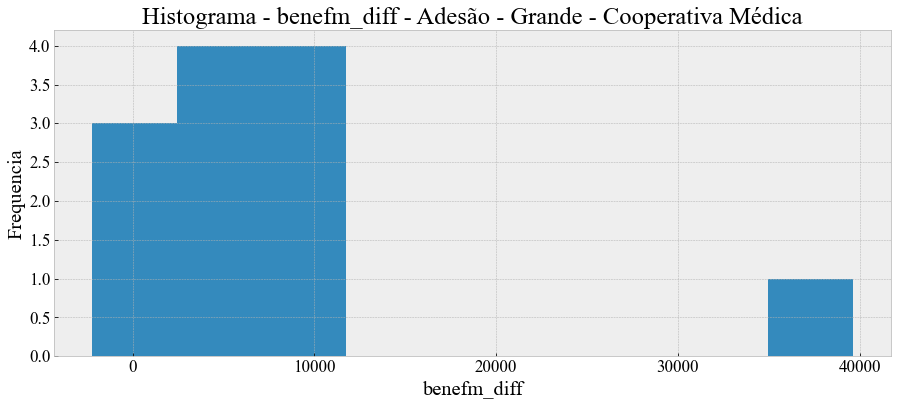

In [12]:
for c in ans_agrup[columns_receita]:
    print(str(c))

    ans_agrup.plot(y = str(c), figsize=(15,6))
    plt.xlabel('Trimestre')
    plt.ylabel(c)
    plt.title(f'{str(c)} - '+ grupo)
    plt.show()

    ans_agrup[str(c)].hist(bins='auto',figsize=(15,6))
    plt.xlabel(str(c))
    plt.ylabel('Frequencia')
    plt.title(f'Histograma - {str(c)} - '+ grupo)
    plt.show()

## Forecast da benef - Random Forest

In [13]:
ans_agrup_benefm = ans_agrup_full[['n_tri','n_tri_l1','benefm','benefm_diff','benefm_diff_l1','benefm_diff_l2','IPCA','Selic','Dolar','Dolar_diff','PNAD','PNAD_diff','dmy_covid']]

ans_agrup_benefm = ans_agrup_benefm.dropna()

ans_agrup_benefm

,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff_l1,benefm_diff_l2,IPCA,Selic,Dolar,Dolar_diff,PNAD,PNAD_diff,dmy_covid
trimestre,,,,,,,,,,,,,
2018Q4,4.000000,3.000000,564459.666667,4895.666667,3774.333333,4035.000000,0.003894,0.000152,3.904500,0.050600,4424.000000,95.000000,1.000000
2019Q1,1.000000,4.000000,566867.333333,2407.666667,4895.666667,3774.333333,0.015070,0.000150,3.776467,-0.128033,4419.000000,-5.000000,1.000000
2019Q2,2.000000,1.000000,576833.333333,9966.000000,2407.666667,4895.666667,0.007108,0.000153,3.903500,0.127033,4327.000000,-92.000000,1.000000
2019Q3,3.000000,2.000000,577843.000000,1009.666667,9966.000000,2407.666667,0.002601,0.000153,3.882133,-0.021367,4286.000000,-41.000000,1.000000
2019Q4,4.000000,3.000000,585833.666667,7990.666667,1009.666667,9966.000000,0.017675,0.000123,4.131167,0.249034,4410.000000,124.000000,1.000000
2020Q1,1.000000,4.000000,625470.000000,39636.333333,7990.666667,1009.666667,0.005308,0.000101,4.191133,0.059966,4355.000000,-55.000000,0.000000
2020Q2,2.000000,1.000000,630837.666667,5367.666667,39636.333333,7990.666667,-0.004306,0.000073,5.272333,1.081200,4009.000000,-346.000000,0.000000
2020Q3,3.000000,2.000000,639071.666667,8234.000000,5367.666667,39636.333333,0.012447,0.000051,5.307533,0.035200,3837.000000,-172.000000,0.000000
2020Q4,4.000000,3.000000,648078.666667,9007.000000,8234.000000,5367.666667,0.031314,0.000047,5.458467,0.150934,3841.000000,4.000000,1.000000


In [14]:
#Create X and y object
X_benefm = ans_agrup_benefm[['n_tri','n_tri_l1','benefm_diff_l1','benefm_diff_l2','IPCA','Selic','Dolar_diff','PNAD_diff','dmy_covid']]
y_benefm = ans_agrup_benefm['benefm_diff']

#Verificação da estacionariedade do número beneficiarios
print('########################################################')
print('Teste Estacionaridade')
print('########################################################')
Augmented_Dickey_Fuller_Test_func(y_benefm, 'benefm_diff')

########################################################
Teste Estacionaridade
########################################################
Results of Dickey-Fuller Test for column benefm_diff
Test Statistic                 -3.233001
p-value                         0.018152
No Lags Used                    0.000000
Number of Observartions Used   12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


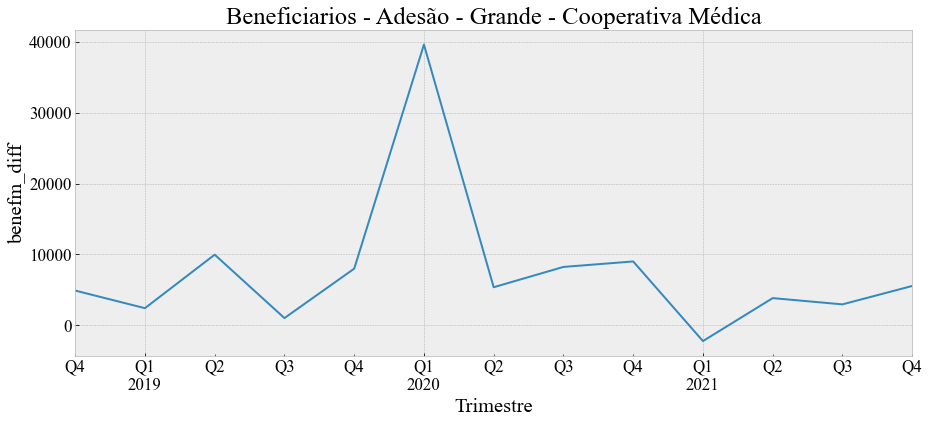

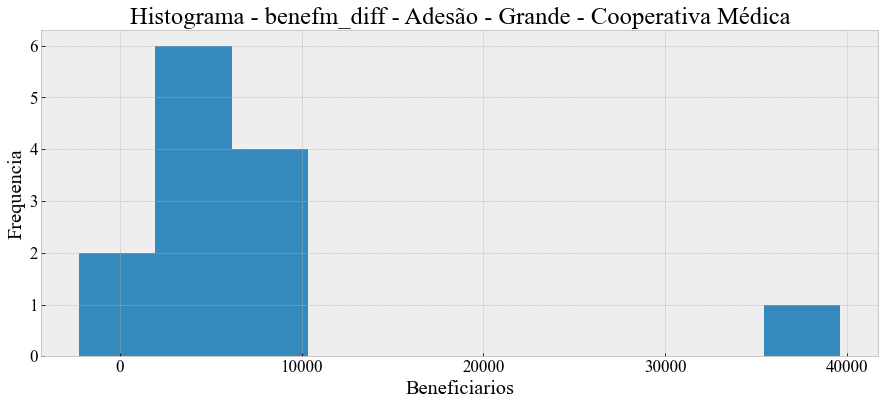

In [15]:
y_benefm.plot(y = 'Beneficiarios', figsize=(15,6))
plt.xlabel('Trimestre')
plt.ylabel(c)
plt.title(f'Beneficiarios - '+ grupo)
plt.show()

y_benefm.hist(bins='auto',figsize=(15,6))
plt.xlabel('Beneficiarios')
plt.ylabel('Frequencia')
plt.title(f'Histograma - {str(c)} - '+ grupo)
plt.show()

In [16]:
# Create Train test split
X_benefm_train, X_benefm_test, y_benefm_train, y_benefm_test = train_test_split(X_benefm,y_benefm, test_size=3, random_state=1234, shuffle=False)

#Normalização dos dados
scaler_X_benefm_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_benefm_train.fit(X_benefm_train)
X_benefm_train_scaled = scaler_X_benefm_train.transform(X_benefm_train)

y_benef_train_reshaped = y_benefm_train.to_numpy().reshape(-1,1)

scaler_y_benefm_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_benefm_train.fit(y_benef_train_reshaped)
y_benefm_train_scaled = scaler_y_benefm_train.transform(y_benef_train_reshaped)

In [17]:
rf_regr_benefm = GridSearchCV( RandomForestRegressor(),
                      {'max_features':[0.5,0.55,0.60,0.65,0.7,0.75,0.8],
                      'n_estimators':[5,10,15,20,30,40,50,100]},
                       scoring='r2', n_jobs=-1, verbose=True)

rf_regr_benefm.fit(X_benefm_train_scaled,y_benefm_train_scaled)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
                         'n_estimators': [5, 10, 15, 20, 30, 40, 50, 100]},
             scoring='r2', verbose=True)

In [18]:
X_benefm_test_scaled = scaler_X_benefm_train.transform(X_benefm_test)

y_benefm_pred_scaled = rf_regr_benefm.predict(X_benefm_test_scaled)
y_benefm_pred = scaler_y_benefm_train.inverse_transform(y_benefm_pred_scaled.reshape(-1,1))
y_benefm_pred = y_benefm_pred.reshape(-1)

#y_pred = rf_regr.predict(X_test)

timeseries_evaluation_metrics_func(list(y_benefm_test),list(y_benefm_pred))
print(rf_regr_benefm.best_params_)

Mean_Squared_Error_(MSE) is : 210029205.9200009
Root_Mean_Squared_Error_(RMSE) is : 14492.38441113128
Mean_Absolute_Error_(MAE) is : 10346.711111111113
Mean_Absolute_Percentage_Error (MAPE) is : 3.2903385899709625
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 0.8833877737702777
Coefficient of determination R^2 is : -179.43281945503998

{'max_features': 0.7, 'n_estimators': 5}


In [19]:
fi = pd.DataFrame( {'features': X_benefm_train.columns,
                    'importance': rf_regr_benefm.best_estimator_.feature_importances_})

fi.sort_values('importance', ascending=False)    

,features,importance
3,benefm_diff_l2,0.595380
8,dmy_covid,0.185241
4,IPCA,0.175446
6,Dolar_diff,0.035772
5,Selic,0.003299
2,benefm_diff_l1,0.001870
7,PNAD_diff,0.001713
1,n_tri_l1,0.001279
0,n_tri,0.000000


In [20]:
df_benefm_pred = pd.DataFrame(y_benefm_pred, columns=['benefm'])
df_benefm_pred

,benefm
0,8242.600000
1,27576.400000
2,7542.800000


In [21]:
actual_df = pd.DataFrame(ans_agrup['benefm'].iloc[:-3])

display(actual_df)

res = inverse_diff(actual_df,df_benefm_pred)

res

,benefm
trimestre,
2019Q1,566867.333333
2019Q2,576833.333333
2019Q3,577843.000000
2019Q4,585833.666667
2020Q1,625470.000000
2020Q2,630837.666667
2020Q3,639071.666667
2020Q4,648078.666667
2021Q1,645841.333333


,benefm,benefm_1st_inv_diff
0,8242.600000,654083.933333
1,27576.400000,681660.333333
2,7542.800000,689203.133333


In [22]:
timeseries_evaluation_metrics_func(list(ans_agrup['benefm'].iloc[-3:]),list(res['benefm_1st_inv_diff']))

Mean_Squared_Error_(MSE) is : 608813448.3555565
Root_Mean_Squared_Error_(RMSE) is : 24674.145341947642
Mean_Absolute_Error_(MAE) is : 21498.5777777778
Mean_Absolute_Percentage_Error (MAPE) is : 0.032818715713469615
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 0.03212600260088367
Coefficient of determination R^2 is : -48.12090937552183



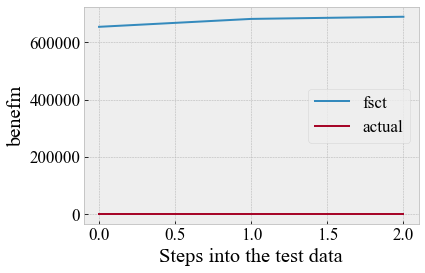

In [23]:
plt.plot(list(res['benefm_1st_inv_diff']))
plt.plot(list(ans_agrup['receita'].iloc[-3:]))
plt.legend(['fsct','actual'])
plt.ylabel('benefm')
plt.xlabel('Steps into the test data')
plt.show()

In [24]:
#dataframe teste para os 3 próximos anos

benefm_l1_list = [y_benefm.iloc[-1]]
benefm_l1_list_temp = [np.nan]*11
benefm_l1_list.extend(benefm_l1_list_temp)

benefm_l2_list = [y_benefm.iloc[-2]]
benefm_l2_list_temp = [np.nan]*11
benefm_l2_list.extend(benefm_l2_list_temp)

ipca_list = [0.032007, 0.02215]
ipca_list_temp = [0.03]*10
ipca_list.extend(ipca_list_temp)

selic_list = [0.000242, 0.000288]
selic_list_temp = [0.0002]*10
selic_list.extend(selic_list_temp)

dolar_list = np.array([ans_agrup_full['Dolar'].iloc[-1], 5.478567, 4.9849, 5.51, 5.65, 5.545, 5.85, 5.90, 6.05, 6.10, 6.15, 6.30, 6.40])
dolar_diff_list = np.diff(dolar_list)

pnad_list = [0.191, 0.140]
pnad_list_temp = [0.120]*10
pnad_list.extend(pnad_list_temp)

input = {'n_tri': [1,2,3,4, 1,2,3,4, 1,2,3,4],
         'n_tri_l1': [4, 1,2,3,4, 1,2,3,4,1,2,3],         
         'benefm_diff_l1':  benefm_l1_list,
         'benefm_diff_l2': benefm_l2_list,         
         'IPCA': ipca_list,
         'Selic': selic_list,
         'Dolar_diff': dolar_diff_list,
         'PNAD_diff': pnad_list, 
         'dmy_covid':[1.0]*12}

index_df_pred_test = [  '2022Q1',
                        '2022Q2',
                        '2022Q3',
                        '2022Q4',
                        '2023Q1',
                        '2023Q2',
                        '2023Q3',
                        '2023Q4',
                        '2024Q1',
                        '2024Q2',
                        '2024Q3',
                        '2024Q4']

df_benef_pred_test = pd.DataFrame(input, index = index_df_pred_test)

df_benef_pred_test

,n_tri,n_tri_l1,benefm_diff_l1,benefm_diff_l2,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid
2022Q1,1,4,5545.333333,2946.666667,0.032007,0.000242,0.102400,0.191000,1.000000
2022Q2,2,1,NaN,NaN,0.022150,0.000288,-0.493667,0.140000,1.000000
2022Q3,3,2,NaN,NaN,0.030000,0.000200,0.525100,0.120000,1.000000
2022Q4,4,3,NaN,NaN,0.030000,0.000200,0.140000,0.120000,1.000000
2023Q1,1,4,NaN,NaN,0.030000,0.000200,-0.105000,0.120000,1.000000
2023Q2,2,1,NaN,NaN,0.030000,0.000200,0.305000,0.120000,1.000000
2023Q3,3,2,NaN,NaN,0.030000,0.000200,0.050000,0.120000,1.000000
2023Q4,4,3,NaN,NaN,0.030000,0.000200,0.150000,0.120000,1.000000
2024Q1,1,4,NaN,NaN,0.030000,0.000200,0.050000,0.120000,1.000000
2024Q2,2,1,NaN,NaN,0.030000,0.000200,0.050000,0.120000,1.000000


In [25]:
y_pred_list = []

for i in range(len(df_benef_pred_test)):
    #X_test = df_pred_test.iloc[i:i+1]
    X_benefm_test = df_benef_pred_test.iloc[:i+1]
    X_benefm_test_scaled_pred = scaler_X_benefm_train.transform(X_benefm_test)

    y_benefm_pred_scaled = rf_regr_benefm.predict(X_benefm_test_scaled_pred)
    y_benefm_pred = scaler_y_benefm_train.inverse_transform(y_benefm_pred_scaled.reshape(-1,1))
    y_benefm_pred = y_benefm_pred.reshape(-1)

    #print(y_pred)
    #y_pred_list.append(y_pred)

    if i < len(df_benef_pred_test)-1:
        df_benef_pred_test['benefm_diff_l1'].iloc[i+1] = y_benefm_pred[-1]
        df_benef_pred_test['benefm_diff_l2'].iloc[i+1] = df_benef_pred_test['benefm_diff_l1'].iloc[i:i+1]

display(df_benef_pred_test)

y_benefm_pred

,n_tri,n_tri_l1,benefm_diff_l1,benefm_diff_l2,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid
2022Q1,1,4,5545.333333,2946.666667,0.032007,0.000242,0.102400,0.191000,1.000000
2022Q2,2,1,7746.066667,5545.333333,0.022150,0.000288,-0.493667,0.140000,1.000000
2022Q3,3,2,5821.866667,7746.066667,0.030000,0.000200,0.525100,0.120000,1.000000
2022Q4,4,3,8459.466667,5821.866667,0.030000,0.000200,0.140000,0.120000,1.000000
2023Q1,1,4,8568.333333,8459.466667,0.030000,0.000200,-0.105000,0.120000,1.000000
2023Q2,2,1,6471.266667,8568.333333,0.030000,0.000200,0.305000,0.120000,1.000000
2023Q3,3,2,8459.466667,6471.266667,0.030000,0.000200,0.050000,0.120000,1.000000
2023Q4,4,3,8662.733333,8459.466667,0.030000,0.000200,0.150000,0.120000,1.000000
2024Q1,1,4,8568.333333,8662.733333,0.030000,0.000200,0.050000,0.120000,1.000000
2024Q2,2,1,8568.333333,8568.333333,0.030000,0.000200,0.050000,0.120000,1.000000


array([7746.06666667, 5821.86666667, 8459.46666667, 8568.33333333,
       6471.26666667, 8459.46666667, 8662.73333333, 8568.33333333,
       8568.33333333, 8662.73333333, 8662.73333333, 8568.33333333])

In [26]:
df_benefm_pred = pd.DataFrame(y_benefm_pred, columns=['benefm'], index = index_df_pred_test)
df_benefm_pred

,benefm
2022Q1,7746.066667
2022Q2,5821.866667
2022Q3,8459.466667
2022Q4,8568.333333
2023Q1,6471.266667
2023Q2,8459.466667
2023Q3,8662.733333
2023Q4,8568.333333
2024Q1,8568.333333
2024Q2,8662.733333


In [27]:
actual_df = pd.DataFrame(ans_agrup_benefm['benefm'])
#actual_df.set_index('trimestre', inplace=True)
pred_res = inverse_diff(actual_df,df_benefm_pred)
pred_res.rename({'benefm_1st_inv_diff': 'benefm_pred'}, axis=1, inplace=True)
pred_res['benefm_pred']

2022Q1   665909.066667
2022Q2   671730.933333
2022Q3   680190.400000
2022Q4   688758.733333
2023Q1   695230.000000
2023Q2   703689.466667
2023Q3   712352.200000
2023Q4   720920.533333
2024Q1   729488.866667
2024Q2   738151.600000
2024Q3   746814.333333
2024Q4   755382.666667
Name: benefm_pred, dtype: float64

In [28]:
ans_agrup_temp = pd.DataFrame(ans_agrup_full['benefm'])
ans_agrup_join = ans_agrup_temp.append(pd.DataFrame(pred_res['benefm_pred']))
ans_agrup_join

,benefm,benefm_pred
2018Q1,551754.666667,NaN
2018Q2,555789.666667,NaN
2018Q3,559564.000000,NaN
2018Q4,564459.666667,NaN
2019Q1,566867.333333,NaN
2019Q2,576833.333333,NaN
2019Q3,577843.000000,NaN
2019Q4,585833.666667,NaN
2020Q1,625470.000000,NaN
2020Q2,630837.666667,NaN


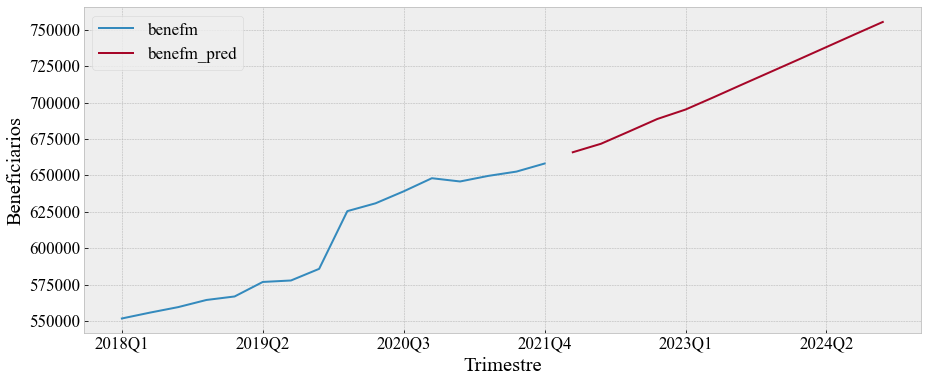

In [29]:
ans_agrup_join.plot(figsize=(15,6))
plt.legend(['benefm','benefm_pred'])
plt.ylabel('Beneficiarios')
plt.xlabel('Trimestre')
plt.show()

In [30]:
df_benefm_pred

,benefm
2022Q1,7746.066667
2022Q2,5821.866667
2022Q3,8459.466667
2022Q4,8568.333333
2023Q1,6471.266667
2023Q2,8459.466667
2023Q3,8662.733333
2023Q4,8568.333333
2024Q1,8568.333333
2024Q2,8662.733333


## Forecast da Receita - Random Forest

In [31]:
ans_agrup_rec = ans_agrup_full[['n_tri','n_tri_l1','receita','receita_diff','receita_diff_l1','receita_diff_l2','benefm_diff','IPCA','Selic','Dolar','Dolar_diff','PNAD','PNAD_diff','dmy_covid']]

ans_agrup_rec = ans_agrup_rec.dropna()

ans_agrup_rec

,n_tri,n_tri_l1,receita,receita_diff,receita_diff_l1,receita_diff_l2,benefm_diff,IPCA,Selic,Dolar,Dolar_diff,PNAD,PNAD_diff,dmy_covid
trimestre,,,,,,,,,,,,,,
2018Q4,4.000000,3.000000,2.380000,0.090000,0.130000,0.010000,4895.666667,0.003894,0.000152,3.904500,0.050600,4424.000000,95.000000,1.000000
2019Q1,1.000000,4.000000,2.370000,-0.010000,0.090000,0.130000,2407.666667,0.015070,0.000150,3.776467,-0.128033,4419.000000,-5.000000,1.000000
2019Q2,2.000000,1.000000,2.460000,0.090000,-0.010000,0.090000,9966.000000,0.007108,0.000153,3.903500,0.127033,4327.000000,-92.000000,1.000000
2019Q3,3.000000,2.000000,2.550000,0.090000,0.090000,-0.010000,1009.666667,0.002601,0.000153,3.882133,-0.021367,4286.000000,-41.000000,1.000000
2019Q4,4.000000,3.000000,2.650000,0.100000,0.090000,0.090000,7990.666667,0.017675,0.000123,4.131167,0.249034,4410.000000,124.000000,1.000000
2020Q1,1.000000,4.000000,2.750000,0.100000,0.100000,0.090000,39636.333333,0.005308,0.000101,4.191133,0.059966,4355.000000,-55.000000,0.000000
2020Q2,2.000000,1.000000,2.790000,0.040000,0.100000,0.100000,5367.666667,-0.004306,0.000073,5.272333,1.081200,4009.000000,-346.000000,0.000000
2020Q3,3.000000,2.000000,2.830000,0.040000,0.040000,0.100000,8234.000000,0.012447,0.000051,5.307533,0.035200,3837.000000,-172.000000,0.000000
2020Q4,4.000000,3.000000,2.980000,0.150000,0.040000,0.040000,9007.000000,0.031314,0.000047,5.458467,0.150934,3841.000000,4.000000,1.000000


In [32]:
#Create X and y object
X_rec = ans_agrup_rec[['n_tri','n_tri_l1','receita_diff_l1','receita_diff_l2','benefm_diff','IPCA','Selic','Dolar_diff','PNAD_diff','dmy_covid']]
y_rec = ans_agrup_rec['receita_diff']

#Verificação da estacionariedade da receita
print('#########################################################################')
print('Teste Estacionaridade')
print('#########################################################################')
Augmented_Dickey_Fuller_Test_func(y_rec, 'receita_diff')

#########################################################################
Teste Estacionaridade
#########################################################################
Results of Dickey-Fuller Test for column receita_diff
Test Statistic                 -5.206978
p-value                         0.000009
No Lags Used                    3.000000
Number of Observartions Used    9.000000
Critical Value (1%)            -4.473135
Critical Value (5%)            -3.289881
Critical Value (10%)           -2.772382
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


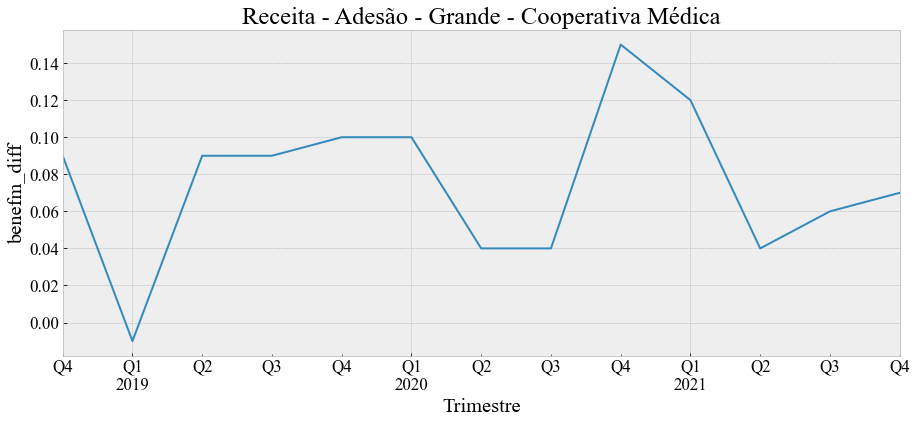

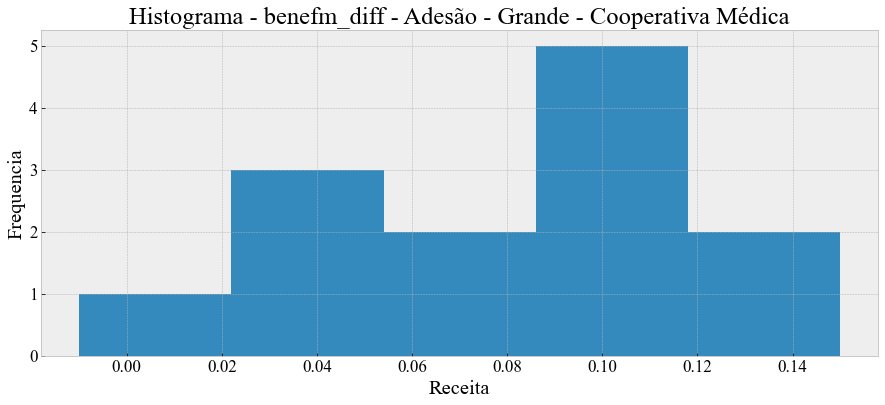

In [33]:
y_rec.plot(y = 'Receita', figsize=(15,6))
plt.xlabel('Trimestre')
plt.ylabel(c)
plt.title(f'Receita - '+ grupo)
plt.show()

y_rec.hist(bins='auto',figsize=(15,6))
plt.xlabel('Receita')
plt.ylabel('Frequencia')
plt.title(f'Histograma - {str(c)} - '+ grupo)
plt.show()

In [34]:
# Create Train test split
X_rec_train, X_rec_test, y_rec_train, y_rec_test = train_test_split(X_rec,y_rec, test_size=3, random_state=1234, shuffle=False)

#Normalização dos dados
scaler_X_rec_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_rec_train.fit(X_rec_train)
X_rec_train_scaled = scaler_X_rec_train.transform(X_rec_train)

y_rec_train_reshaped = y_rec_train.to_numpy().reshape(-1,1)

scaler_y_rec_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_rec_train.fit(y_rec_train_reshaped)
y_rec_train_scaled = scaler_y_rec_train.transform(y_rec_train_reshaped)

In [35]:
rf_regr_rec = GridSearchCV(RandomForestRegressor(),
                           {'max_features':[0.5,0.55,0.60,0.65,0.7,0.75,0.8],
                            'n_estimators':[5,10,15,20,30,40,50,100]},
                             scoring='r2', n_jobs=-1, verbose=True)

rf_regr_rec.fit(X_rec_train_scaled,y_rec_train_scaled)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
                         'n_estimators': [5, 10, 15, 20, 30, 40, 50, 100]},
             scoring='r2', verbose=True)

In [36]:
X_rec_test_scaled = scaler_X_rec_train.transform(X_rec_test)

y_rec_pred = rf_regr_rec.predict(X_rec_test_scaled)
y_rec_pred = scaler_y_rec_train.inverse_transform(y_rec_pred.reshape(-1,1))
y_rec_pred = y_rec_pred.reshape(-1)

#y_pred = rf_regr.predict(X_test)

timeseries_evaluation_metrics_func(list(y_rec_test),list(y_rec_pred))
print(rf_regr_rec.best_params_)

Mean_Squared_Error_(MSE) is : 0.0009213333333333344
Root_Mean_Squared_Error_(RMSE) is : 0.03035347316755258
Mean_Absolute_Error_(MAE) is : 0.02733333333333331
Mean_Absolute_Percentage_Error (MAPE) is : 0.46904761904761855
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 0.47606999789162807
Coefficient of determination R^2 is : -4.9228571428572145

{'max_features': 0.5, 'n_estimators': 5}


In [37]:
fi = pd.DataFrame( {'features': X_rec_train.columns,
                    'importance': rf_regr_rec.best_estimator_.feature_importances_})

fi.sort_values('importance', ascending=False)    

,features,importance
3,receita_diff_l2,0.543704
0,n_tri,0.152210
5,IPCA,0.112037
6,Selic,0.089700
7,Dolar_diff,0.041722
2,receita_diff_l1,0.023192
1,n_tri_l1,0.021915
9,dmy_covid,0.014468
8,PNAD_diff,0.001052
4,benefm_diff,0.000000


In [38]:
df_rec_pred = pd.DataFrame(y_rec_pred, columns=['receita'])
df_rec_pred

,receita
0,0.022000
1,0.042000
2,0.116000


In [39]:
actual_df_rec = pd.DataFrame(ans_agrup['receita'].iloc[:-3])

display(actual_df_rec)

res_rec = inverse_diff(actual_df_rec,df_rec_pred)

res_rec

,receita
trimestre,
2019Q1,2.370000
2019Q2,2.460000
2019Q3,2.550000
2019Q4,2.650000
2020Q1,2.750000
2020Q2,2.790000
2020Q3,2.830000
2020Q4,2.980000
2021Q1,3.100000


,receita,receita_1st_inv_diff
0,0.022000,3.122000
1,0.042000,3.164000
2,0.116000,3.280000


In [40]:
timeseries_evaluation_metrics_func(list(ans_agrup['receita'].iloc[-3:]),list(res_rec['receita_1st_inv_diff']))

Mean_Squared_Error_(MSE) is : 0.0005733333333333331
Root_Mean_Squared_Error_(RMSE) is : 0.02394437999475729
Mean_Absolute_Error_(MAE) is : 0.021333333333333353
Mean_Absolute_Percentage_Error (MAPE) is : 0.0066801960173227684
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 0.006705345442697762
Coefficient of determination R^2 is : 0.7968503937007871



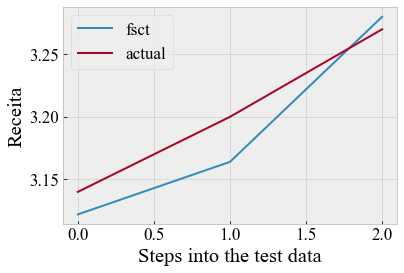

In [41]:
plt.plot(list(res_rec['receita_1st_inv_diff']))
plt.plot(list(ans_agrup['receita'].iloc[-3:]))
plt.legend(['fsct','actual'])
plt.ylabel('Receita')
plt.xlabel('Steps into the test data')
plt.show()

In [43]:
#dataframe teste para os 3 próximos anos

receita_l1_list = [y_rec.iloc[-1]]
receita_l1_list_temp = [np.nan]*11
receita_l1_list.extend(receita_l1_list_temp)

receita_l2_list = [y_rec.iloc[-2]]
receita_l2_list_temp = [np.nan]*11
receita_l2_list.extend(receita_l2_list_temp)

ipca_list = [0.032007, 0.02215]
ipca_list_temp = [0.03]*10
ipca_list.extend(ipca_list_temp)

selic_list = [0.000242, 0.000288]
selic_list_temp = [0.0002]*10
selic_list.extend(selic_list_temp)

benefm_diff_list = [ans_agrup_rec['benefm_diff'].iloc[-3]]*12

dolar_list = np.array([ans_agrup_full['Dolar'].iloc[-1], 5.478567, 4.9849, 5.51, 5.65, 5.545, 5.85, 5.90, 6.05, 6.10, 6.15, 6.30, 6.40])
dolar_diff_list = np.diff(dolar_list)

input = {'n_tri': [1,2,3,4, 1,2,3,4, 1,2,3,4],
         'n_tri_l1': [4, 1,2,3,4, 1,2,3,4,1,2,3],         
         'receita_diff_l1':  receita_l1_list,
         'receita_diff_l2': receita_l2_list,
         'benefm': benefm_diff_list,
         'IPCA': ipca_list,
         'Selic': selic_list,
         'Dolar_diff': dolar_diff_list,
         'dmy_covid':[1.0]*12}

index_df_pred_test = [  '2022Q1',
                        '2022Q2',
                        '2022Q3',
                        '2022Q4',
                        '2023Q1',
                        '2023Q2',
                        '2023Q3',
                        '2023Q4',
                        '2024Q1',
                        '2024Q2',
                        '2024Q3',
                        '2024Q4']

df_pred_test = pd.DataFrame(input, index = index_df_pred_test)

df_pred_test

,n_tri,n_tri_l1,receita_diff_l1,receita_diff_l2,benefm,IPCA,Selic,Dolar_diff,dmy_covid
2022Q1,1,4,0.070000,0.060000,3829.666667,0.032007,0.000242,0.102400,1.000000
2022Q2,2,1,NaN,NaN,3829.666667,0.022150,0.000288,-0.493667,1.000000
2022Q3,3,2,NaN,NaN,3829.666667,0.030000,0.000200,0.525100,1.000000
2022Q4,4,3,NaN,NaN,3829.666667,0.030000,0.000200,0.140000,1.000000
2023Q1,1,4,NaN,NaN,3829.666667,0.030000,0.000200,-0.105000,1.000000
2023Q2,2,1,NaN,NaN,3829.666667,0.030000,0.000200,0.305000,1.000000
2023Q3,3,2,NaN,NaN,3829.666667,0.030000,0.000200,0.050000,1.000000
2023Q4,4,3,NaN,NaN,3829.666667,0.030000,0.000200,0.150000,1.000000
2024Q1,1,4,NaN,NaN,3829.666667,0.030000,0.000200,0.050000,1.000000
2024Q2,2,1,NaN,NaN,3829.666667,0.030000,0.000200,0.050000,1.000000


In [44]:
y_pred_list = []

for i in range(len(df_pred_test)):
    #X_test = df_pred_test.iloc[i:i+1]
    X_test = df_pred_test.iloc[:i+1]
    X_test_scaled_test = scaler_X_rec_train.transform(X_test)

    y_pred = rf_regr.predict(X_test_scaled_test)
    y_pred = scaler_y_train.inverse_transform(y_pred.reshape(-1,1))
    y_pred = y_pred.reshape(-1)

    #print(y_pred)
    #y_pred_list.append(y_pred)

    if i < len(df_pred_test)-1:
        df_pred_test['receita_diff_l1'].iloc[i+1] = y_pred[-1]
        df_pred_test['receita_diff_l2'].iloc[i+1] = df_pred_test['receita_diff_l1'].iloc[i:i+1]

display(df_pred_test)

y_pred

ValueError: X has 9 features, but MinMaxScaler is expecting 10 features as input.

In [ ]:
df_pred = pd.DataFrame(y_pred, columns=['receita'], index = index_df_pred_test)
df_pred

,receita
2022Q1,0.116000
2022Q2,0.110000
2022Q3,0.086000
2022Q4,0.086000
2023Q1,0.116000
2023Q2,0.116000
2023Q3,0.086000
2023Q4,0.086000
2024Q1,0.116000
2024Q2,0.116000


In [ ]:
actual_df = pd.DataFrame(ans_agrup_rec['receita'])
#actual_df.set_index('trimestre', inplace=True)
pred_res = inverse_diff(actual_df,df_pred)
pred_res.rename({'receita_1st_inv_diff': 'receita_pred'}, axis=1, inplace=True)
pred_res['receita_pred']

2022Q1   3.386000
2022Q2   3.496000
2022Q3   3.582000
2022Q4   3.668000
2023Q1   3.784000
2023Q2   3.900000
2023Q3   3.986000
2023Q4   4.072000
2024Q1   4.188000
2024Q2   4.304000
2024Q3   4.390000
2024Q4   4.476000
Name: receita_pred, dtype: float64

In [ ]:
ans_agrup_temp = pd.DataFrame(ans_agrup_full['receita'])
ans_agrup_join = ans_agrup_temp.append(pd.DataFrame(pred_res['receita_pred']))
ans_agrup_join

,receita,receita_pred
2018Q1,2.150000,NaN
2018Q2,2.160000,NaN
2018Q3,2.290000,NaN
2018Q4,2.380000,NaN
2019Q1,2.370000,NaN
2019Q2,2.460000,NaN
2019Q3,2.550000,NaN
2019Q4,2.650000,NaN
2020Q1,2.750000,NaN
2020Q2,2.790000,NaN


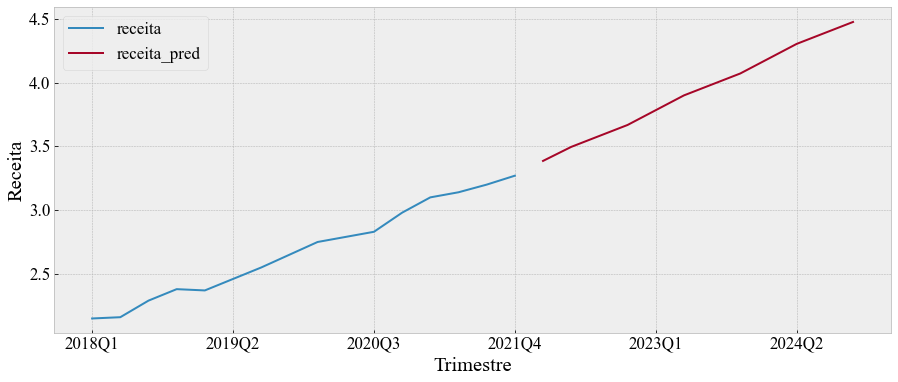

In [ ]:
ans_agrup_join.plot(figsize=(15,6))
plt.legend(['receita','receita_pred'])
plt.ylabel('Receita')
plt.xlabel('Trimestre')
plt.show()

## Forecast Despesa

In [ ]:
ans_agrup_desp = ans_agrup_full[['n_tri','n_tri_l1','n_ops','despesa','despesa_diff','despesa_diff_l1','despesa_diff_l2','benefm_diff','IPCA','Selic','Dolar','Dolar_diff','dmy_covid']]

ans_agrup_desp = ans_agrup_desp.dropna()

#Create X and y object
X = ans_agrup_desp[['n_tri','n_tri_l1','n_ops','despesa_diff_l1','despesa_diff_l2','benefm_diff','IPCA','Selic','Dolar','dmy_covid']]
y = ans_agrup_desp['despesa_diff']

Augmented_Dickey_Fuller_Test_func(y, 'despesa')

Results of Dickey-Fuller Test for column despesa
Test Statistic                 -2.139302
p-value                         0.229007
No Lags Used                    4.000000
Number of Observartions Used    8.000000
Critical Value (1%)            -4.665186
Critical Value (5%)            -3.367187
Critical Value (10%)           -2.802961
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


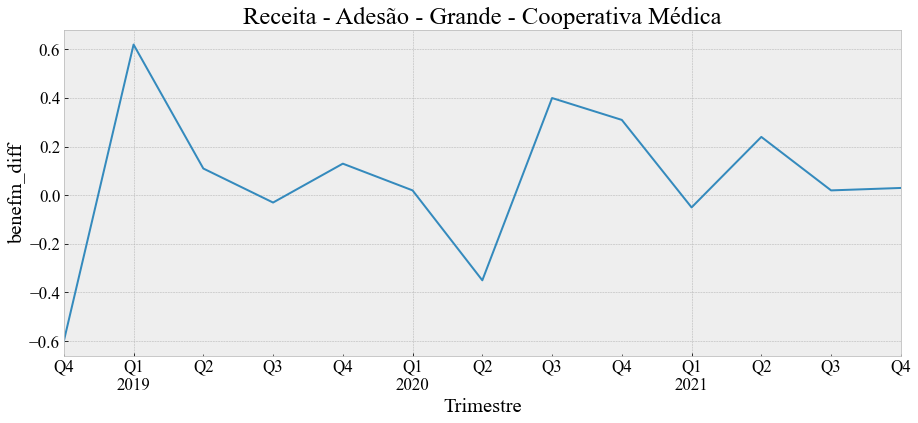

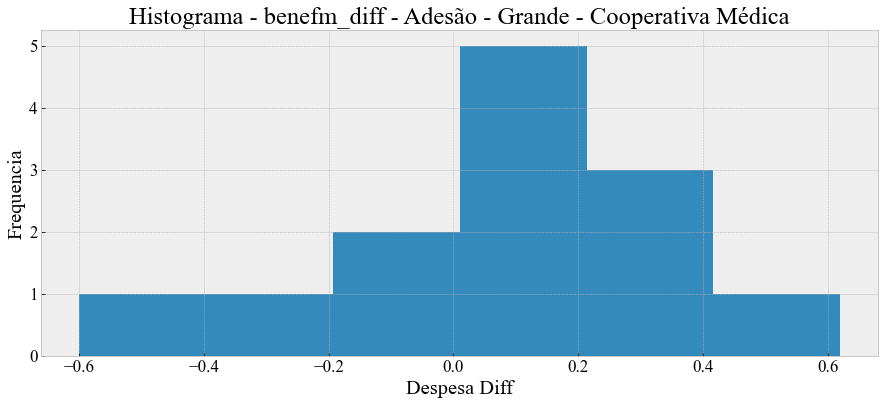

In [ ]:
y.plot(y = 'Despesa', figsize=(15,6))
plt.xlabel('Trimestre')
plt.ylabel(c)
plt.title(f'Receita - '+ grupo)
plt.show()

y.hist(bins='auto',figsize=(15,6))
plt.xlabel('Despesa Diff')
plt.ylabel('Frequencia')
plt.title(f'Histograma - {str(c)} - '+ grupo)
plt.show()

In [ ]:
# Create Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=3, random_state=1234, shuffle=False)

#Normalização dos dados
scaler_X_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_train.fit(X_train)
X_train_scaled = scaler_X_train.transform(X_train)

y_train_reshaped = y_train.to_numpy().reshape(-1,1)

scaler_y_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_train.fit(y_train_reshaped)
y_train_scaled = scaler_y_train.transform(y_train_reshaped)

In [ ]:
rf_regr = GridSearchCV( RandomForestRegressor(),
                      {'max_features':[0.5,0.55,0.60,0.65,0.7,0.75,0.8],
                      'n_estimators':[5,10,15,20,30,40,50,100]},
                       scoring='r2', n_jobs=-1, verbose=True)

rf_regr.fit(X_train_scaled,y_train_scaled)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
                         'n_estimators': [5, 10, 15, 20, 30, 40, 50, 100]},
             scoring='r2', verbose=True)

In [ ]:
X_test_scaled = scaler_X_train.transform(X_test)

y_pred = rf_regr.predict(X_test_scaled)
y_pred = scaler_y_train.inverse_transform(y_pred.reshape(-1,1))
y_pred = y_pred.reshape(-1)

#y_pred = rf_regr.predict(X_test)

timeseries_evaluation_metrics_func(list(y_test),list(y_pred))
print(rf_regr.best_params_)

Mean_Squared_Error_(MSE) is : 0.01348370833333329
Root_Mean_Squared_Error_(RMSE) is : 0.11611937105123026
Mean_Absolute_Error_(MAE) is : 0.07833333333333313
Mean_Absolute_Percentage_Error (MAPE) is : 0.8711805555555513
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 0.8059227621286755
Coefficient of determination R^2 is : -0.3105116090712745

{'max_features': 0.5, 'n_estimators': 40}


In [ ]:
fi = pd.DataFrame( {'features': X_train.columns,
                    'importance': rf_regr.best_estimator_.feature_importances_})

fi.sort_values('importance', ascending=False)    

,features,importance
6,IPCA,0.311339
3,despesa_diff_l1,0.206903
8,Dolar,0.112868
7,Selic,0.103713
4,despesa_diff_l2,0.070897
5,benefm_diff,0.068493
1,n_tri_l1,0.044161
0,n_tri,0.032512
9,dmy_covid,0.024557
2,n_ops,0.024556


In [ ]:
df_pred = pd.DataFrame(y_pred, columns=['despesa'])
df_pred

,despesa
0,0.041750
1,0.053750
2,0.033000


In [ ]:
actual_df = pd.DataFrame(ans_agrup_desp['despesa'].iloc[:-3])

display(actual_df)

res = inverse_diff(actual_df,df_pred)

res

,despesa
trimestre,
2018Q4,1.250000
2019Q1,1.870000
2019Q2,1.980000
2019Q3,1.950000
2019Q4,2.080000
2020Q1,2.100000
2020Q2,1.750000
2020Q3,2.150000
2020Q4,2.460000


,despesa,despesa_1st_inv_diff
0,0.041750,2.451750
1,0.053750,2.505500
2,0.033000,2.538500


In [ ]:
timeseries_evaluation_metrics_func(list(ans_agrup['despesa'].iloc[-3:]),list(res['despesa_1st_inv_diff']))

Mean_Squared_Error_(MSE) is : 0.030815187499999935
Root_Mean_Squared_Error_(RMSE) is : 0.1755425518214884
Mean_Absolute_Error_(MAE) is : 0.17474999999999982
Mean_Absolute_Percentage_Error (MAPE) is : 0.06541220748697245
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 0.0676486796950078
Coefficient of determination R^2 is : -71.98333881578851



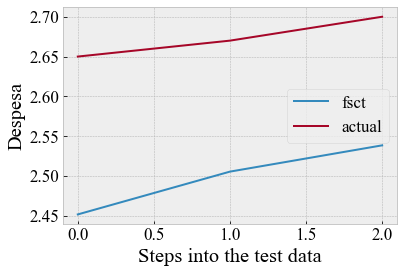

In [ ]:
plt.plot(list(res['despesa_1st_inv_diff']))
plt.plot(list(ans_agrup['despesa'].iloc[-3:]))
plt.legend(['fsct','actual'])
plt.ylabel('Despesa')
plt.xlabel('Steps into the test data')
plt.show()

In [ ]:
#dataframe teste para os 3 próximos anos

despesa_l1_list = [y.iloc[-1]]
despesa_l1_list_temp = [np.nan]*11
despesa_l1_list.extend(despesa_l1_list_temp)

despesa_l2_list = [y.iloc[-2]]
despesa_l2_list_temp = [np.nan]*11
despesa_l2_list.extend(despesa_l2_list_temp)

ipca_list = [0.032007, 0.02215]
ipca_list_temp = [0.03]*10
ipca_list.extend(ipca_list_temp)

selic_list = [0.000242, 0.000288]
selic_list_temp = [0.0002]*10
selic_list.extend(selic_list_temp)

benefm_diff_list = [ans_agrup_rec['benefm_diff'].iloc[-3]]*12

dolar_list = np.array([ans_agrup_full['Dolar'].iloc[-1], 5.478567, 4.9849, 5.51, 5.65, 5.545, 5.85, 5.90, 6.05, 6.10, 6.15, 6.30, 6.40])
dolar_diff_list = np.diff(dolar_list)


input = {'n_tri': [1,2,3,4, 1,2,3,4, 1,2,3,4],
         'n_tri_l1': [4, 1,2,3,4, 1,2,3,4,1,2,3],
         'n_ops': [39.0]*12,
         'despesa_diff_l1':  despesa_l1_list,
         'despesa_diff_l2': despesa_l2_list,
         'benefm_diff': benefm_diff_list,
         'IPCA': ipca_list,
         'Selic': selic_list,
         'Dolar_diff': dolar_diff_list,
         'dmy_covid':[1.0]*12}

index_df_pred_test = [  '2022Q1',
                        '2022Q2',
                        '2022Q3',
                        '2022Q4',
                        '2023Q1',
                        '2023Q2',
                        '2023Q3',
                        '2023Q4',
                        '2024Q1',
                        '2024Q2',
                        '2024Q3',
                        '2024Q4']

df_pred_test = pd.DataFrame(input, index = index_df_pred_test)

df_pred_test

,n_tri,n_tri_l1,n_ops,despesa_diff_l1,despesa_diff_l2,benefm_diff,IPCA,Selic,Dolar_diff,dmy_covid
2022Q1,1,4,39.000000,0.030000,0.020000,3829.666667,0.032007,0.000242,0.102400,1.000000
2022Q2,2,1,39.000000,NaN,NaN,3829.666667,0.022150,0.000288,-0.493667,1.000000
2022Q3,3,2,39.000000,NaN,NaN,3829.666667,0.030000,0.000200,0.525100,1.000000
2022Q4,4,3,39.000000,NaN,NaN,3829.666667,0.030000,0.000200,0.140000,1.000000
2023Q1,1,4,39.000000,NaN,NaN,3829.666667,0.030000,0.000200,-0.105000,1.000000
2023Q2,2,1,39.000000,NaN,NaN,3829.666667,0.030000,0.000200,0.305000,1.000000
2023Q3,3,2,39.000000,NaN,NaN,3829.666667,0.030000,0.000200,0.050000,1.000000
2023Q4,4,3,39.000000,NaN,NaN,3829.666667,0.030000,0.000200,0.150000,1.000000
2024Q1,1,4,39.000000,NaN,NaN,3829.666667,0.030000,0.000200,0.050000,1.000000
2024Q2,2,1,39.000000,NaN,NaN,3829.666667,0.030000,0.000200,0.050000,1.000000


In [ ]:
y_pred_list = []

for i in range(len(df_pred_test)):
    #X_test = df_pred_test.iloc[i:i+1]
    X_test = df_pred_test.iloc[:i+1]
    X_test_scaled_test = scaler_X_train.transform(X_test)

    y_pred = rf_regr.predict(X_test_scaled_test)
    y_pred = scaler_y_train.inverse_transform(y_pred.reshape(-1,1))
    y_pred = y_pred.reshape(-1)

    #print(y_pred)
    #y_pred_list.append(y_pred)

    if i < len(df_pred_test)-1:
        df_pred_test['despesa_diff_l1'].iloc[i+1] = y_pred[-1]
        df_pred_test['despesa_diff_l2'].iloc[i+1] = df_pred_test['despesa_diff_l1'].iloc[i:i+1]

display(df_pred_test)

y_pred

,n_tri,n_tri_l1,n_ops,despesa_diff_l1,despesa_diff_l2,benefm_diff,IPCA,Selic,Dolar_diff,dmy_covid
2022Q1,1,4,39.000000,0.030000,0.020000,3829.666667,0.032007,0.000242,0.102400,1.000000
2022Q2,2,1,39.000000,0.147750,0.030000,3829.666667,0.022150,0.000288,-0.493667,1.000000
2022Q3,3,2,39.000000,0.105750,0.147750,3829.666667,0.030000,0.000200,0.525100,1.000000
2022Q4,4,3,39.000000,0.085500,0.105750,3829.666667,0.030000,0.000200,0.140000,1.000000
2023Q1,1,4,39.000000,0.063250,0.085500,3829.666667,0.030000,0.000200,-0.105000,1.000000
2023Q2,2,1,39.000000,0.131250,0.063250,3829.666667,0.030000,0.000200,0.305000,1.000000
2023Q3,3,2,39.000000,0.100500,0.131250,3829.666667,0.030000,0.000200,0.050000,1.000000
2023Q4,4,3,39.000000,0.085500,0.100500,3829.666667,0.030000,0.000200,0.150000,1.000000
2024Q1,1,4,39.000000,0.063250,0.085500,3829.666667,0.030000,0.000200,0.050000,1.000000
2024Q2,2,1,39.000000,0.131250,0.063250,3829.666667,0.030000,0.000200,0.050000,1.000000


array([0.14775, 0.10575, 0.0855 , 0.06325, 0.13125, 0.1005 , 0.0855 ,
       0.06325, 0.13125, 0.1005 , 0.0855 , 0.06325])

In [ ]:
df_pred = pd.DataFrame(y_pred, columns=['despesa'], index = index_df_pred_test)
df_pred

,despesa
2022Q1,0.147750
2022Q2,0.105750
2022Q3,0.085500
2022Q4,0.063250
2023Q1,0.131250
2023Q2,0.100500
2023Q3,0.085500
2023Q4,0.063250
2024Q1,0.131250
2024Q2,0.100500


In [ ]:
actual_df = pd.DataFrame(ans_agrup_desp['despesa'])
#actual_df.set_index('trimestre', inplace=True)
pred_res = inverse_diff(actual_df,df_pred)
pred_res.rename({'despesa_1st_inv_diff': 'despesa_pred'}, axis=1, inplace=True)
pred_res['despesa_pred']

2022Q1   2.847750
2022Q2   2.953500
2022Q3   3.039000
2022Q4   3.102250
2023Q1   3.233500
2023Q2   3.334000
2023Q3   3.419500
2023Q4   3.482750
2024Q1   3.614000
2024Q2   3.714500
2024Q3   3.800000
2024Q4   3.863250
Name: despesa_pred, dtype: float64

In [ ]:
ans_agrup_temp = pd.DataFrame(ans_agrup_full['despesa'])
ans_agrup_join = ans_agrup_temp.append(pd.DataFrame(pred_res['despesa_pred']))
ans_agrup_join

,despesa,despesa_pred
2018Q1,1.580000,NaN
2018Q2,1.640000,NaN
2018Q3,1.850000,NaN
2018Q4,1.250000,NaN
2019Q1,1.870000,NaN
2019Q2,1.980000,NaN
2019Q3,1.950000,NaN
2019Q4,2.080000,NaN
2020Q1,2.100000,NaN
2020Q2,1.750000,NaN


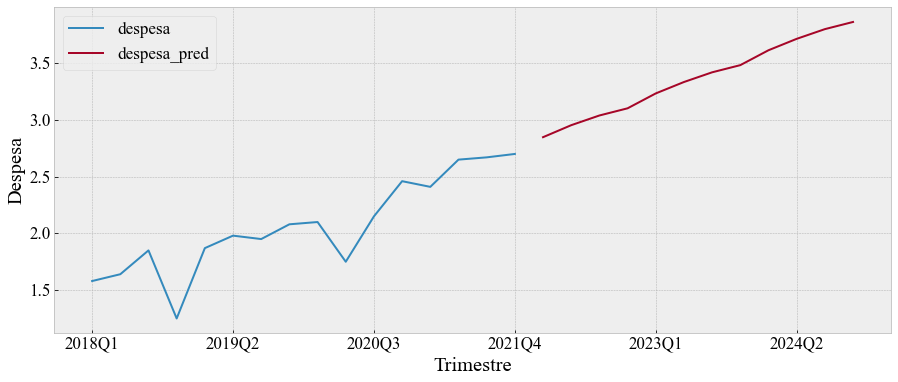

In [ ]:
ans_agrup_join.plot(figsize=(15,6))
plt.legend(['despesa','despesa_pred'])
plt.ylabel('Despesa')
plt.xlabel('Trimestre')
plt.show()